# Question 4: Eliminating Residual Connections

In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = self.dropout_2(self.ff(x2))  # No residual connection
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

In [6]:
def nopeak_mask(size, device):
    np_mask = torch.triu(torch.ones((1, size, size), device=device), 1).bool()
    return np_mask


def create_src_mask(src, pad_token_id, device):
    src_mask = (src != pad_token_id).unsqueeze(-2)
    return src_mask

## Data Feeder

### Tokenizer

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

In [9]:
def tokenize(text):
    tokens = TOKENIZER.encode(
        text,
        add_special_tokens=True,
        max_length=512,  # sequence length
        truncation=True,
    )
    return tokens

In [10]:
def load_dataset(path):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                src_line = line.strip()
                examples.append(data.Example.fromlist([src_line], [("src", SRC)]))
    dataset = data.Dataset(examples, [("src", SRC)])
    return dataset

### BucketIterator

In [11]:
SRC = data.Field(
    use_vocab=False,
    tokenize=tokenize,
    pad_token=TOKENIZER.pad_token_id,
    unk_token=TOKENIZER.unk_token_id,
    init_token=TOKENIZER.bos_token_id,
    eos_token=TOKENIZER.eos_token_id,
    lower=False,
    batch_first=True,
    fix_length=512,
)

In [12]:
train_data = load_dataset("data/wiki2.train.txt")

In [13]:
valid_data = load_dataset("data/wiki2.valid.txt")

## Training

In [14]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [15]:
def train_model(
    model, train_iterator, valid_iterator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        for i, batch in enumerate(train_iterator):
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = src[:, 1:].contiguous().view(-1)  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / len(train_iterator))
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{(time.time() - start) // 60}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

        avg_train_loss = total_train_loss / len(train_iterator)
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_iterator):
                src = batch.src.to(device)
                src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
                no_peak_mask = nopeak_mask(src.size(1), device)

                preds = model(src, src_mask & no_peak_mask)
                preds = preds[:, :-1, :]
                ys = src[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_iterator)
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

### Training the Model

In [16]:
train_iterator = data.BucketIterator(
    train_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [17]:
valid_iterator = data.BucketIterator(
    valid_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [18]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
results = train_model(
    model, train_iterator, valid_iterator, optimizer, DEVICE, epochs=5, print_every=50
)

Epoch 1: Train loss = 7.209, Train Perplexity = 1351.163
Epoch 1: Validation loss = 6.721, Validation Perplexity = 829.476
Epoch 2: Train loss = 7.134, Train Perplexity = 1253.954
Epoch 2: Validation loss = 6.716, Validation Perplexity = 825.610
Epoch 3: Train loss = 7.128, Train Perplexity = 1246.844
Epoch 3: Validation loss = 6.715, Validation Perplexity = 824.577
Epoch 4: Train loss = 6.655, Train Perplexity = 776.988
Epoch 4: Validation loss = 5.780, Validation Perplexity = 323.627
Epoch 5: Train loss = 6.250, Train Perplexity = 518.032
Epoch 5: Validation loss = 5.617, Validation Perplexity = 274.949


In [20]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

### Training Results

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


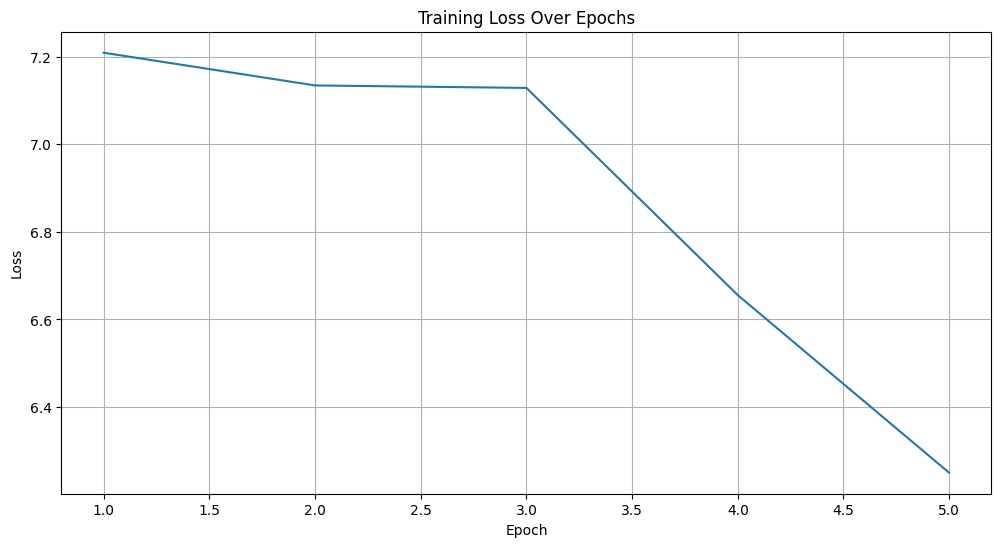

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


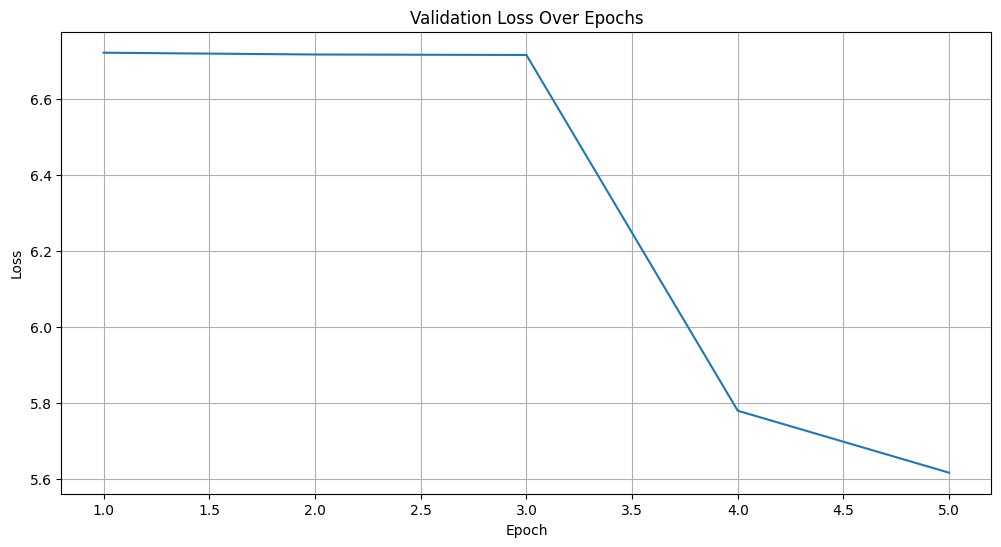

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


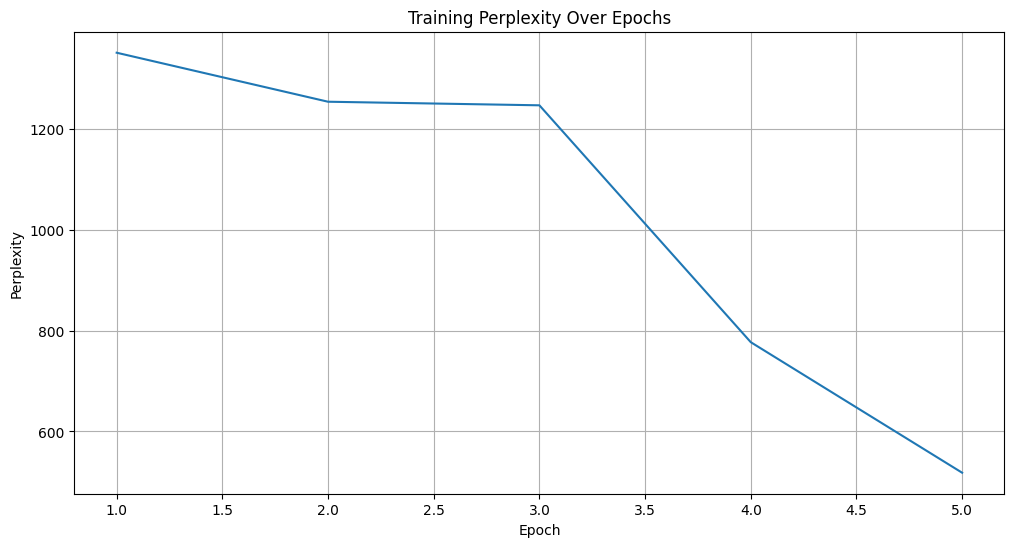

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


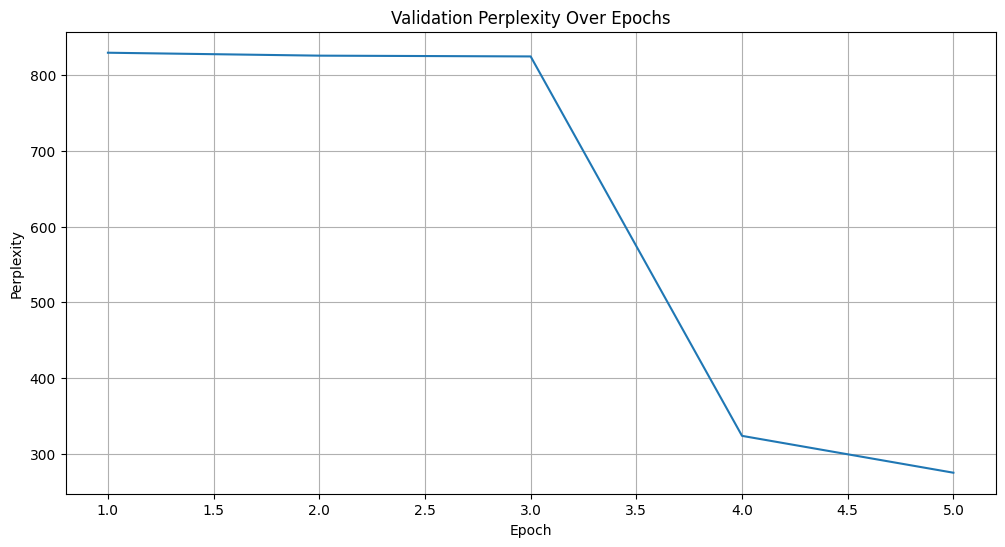

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## Testing

In [27]:
torch.save(model.state_dict(), "model_wgts/model_weights_q4.pth")

In [28]:
test_data = load_dataset("data/wiki2.test.txt")

In [29]:
saved_model = get_model(
    vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE
)

In [31]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights_q4.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [32]:
test_iterator = data.BucketIterator(
    test_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [33]:
def test_model(model, iterator, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = (
                src[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position, assuming next-word prediction

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(iterator)
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [34]:
loss, perplexity = test_model(saved_model, test_iterator, DEVICE)

In [35]:
print("Average Loss:", loss)

Average Loss: 5.4798951971119845


In [36]:
print("Perplexity:", perplexity)

Perplexity: 239.82154846191406


* The residual connections allow the gradient to flow directly through the network during backpropagation, mitigating issues related to the vanishing gradient problem.
* This is especially vital in deep networks like Transformers, where multiple layers can lead to gradients becoming too small (vanishing) or too large (exploding) as they propagate back through the network during training.
* This in a way is a regularization effect, help layers learn identity functions, which can be crucial when additional layers do not necessarily add new information.
* Without residual connections, the model must rely entirely on the current layer's transformations to propagate information.
* Which is what's causing our perplexities to be suboptimal.

## Using Saved Weights

In [37]:
def predict_next_token(text, model, tokenizer, device):
    token_ids = tokenizer.encode(text, return_tensors="pt")
    token_ids = token_ids.to(device)

    src_mask = create_src_mask(token_ids, tokenizer.pad_token_id, DEVICE)

    model.eval()

    with torch.no_grad():
        outputs = model(token_ids, src_mask)

    logits = outputs[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_token_id = torch.argmax(probs).item()

    predicted_token = tokenizer.decode([predicted_token_id])

    return predicted_token

In [38]:
def predict_next_n_tokens(text, model, tokenizer, device, n):
    for _ in range(n):
        next_token = predict_next_token(text, model, tokenizer, device)
        text += " " + next_token
    return text

In [39]:
text = """When Japan began the Pacific War on 8 December , the sisters sortied for the <unk>
 Islands with four other battleships and the light carrier <unk> as distant cover for the fleet
 attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied
 from their anchorage at <unk> to join the unsuccessful search for the American carrier force that
 had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American
 carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,"""
n = 10

In [40]:
predicted_sequence = predict_next_n_tokens(text, model, TOKENIZER, DEVICE, n)
print("Extended sequence with predicted tokens:", predicted_sequence)

Extended sequence with predicted tokens: When Japan began the Pacific War on 8 December , the sisters sortied for the <unk>
 Islands with four other battleships and the light carrier <unk> as distant cover for the fleet
 attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied
 from their anchorage at <unk> to join the unsuccessful search for the American carrier force that
 had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American
 carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,  the  < unk ,  the  < unk ,  the  <


Ground Truth:

```txt
When Japan began the Pacific War on 8 December , the sisters sortied for the <unk> Islands with four other battleships and the light carrier <unk> as distant cover for the fleet attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied from their anchorage at <unk> to join the unsuccessful search for the American carrier force that had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May , [there was a premature detonation in the left gun]
```